# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [ ]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    return (convert_label(data_line[1]), data_line[2])

In [ ]:
import re

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    print("original:", text)
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = re.split(r"\s+",text)
    # normalisation - only by lower casing for now
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [ ]:
# turn each line in the file into a feature vectors
global_feature_dict = {}  # Global feature dictionary maps from words/features to unique index
i = 0 # index counter variable for the global feature dict

def to_feature_vector(tokens, training=True):
    """Convert word tokens into a feature vector dictionary of
    feature index keys and weight values.
    
    Update the featureVector if in training phase, i.e. where training=True.
    """
    
    featureVector = {}  # local feature vector for this example (in dict form)
    for w in tokens:
        
        # First add to the global feature dictionary, and give it a position
        # if in training
        try:
            # if the word w is in the dictionary,
            # then assign i to its value in the dictionary
            i = global_feature_dict[w]
        except KeyError:
            # else if it's not in the dictionary,
            # it's a new feature in training, add new entry
            if training:
                i = len(global_feature_dict) + 1
                global_feature_dict[w] = i
            else:
                # At test time don't add new entry
                i = global_feature_dict["<unk/>"]  # get the special unknown word token
        
        # Add to local feature vector (as a dictionary entry with a weight)

        try:
            # if the word w is in the local feature vector (repeat word), add 1/n weight
            featureVector[i] += 1 #(1.0/len(words))
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[i] = 1 #(1.0/len(words))
            
        if False:
            # example binary alternative to the above (just add it as 1 if present)
            if not i in featureVector.keys():
                featureVector[i] = 1
        
            
    return featureVector

In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [ ]:
from nltk.classify.maxent import ConditionalExponentialClassifier
#solution
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import statistics

def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    p_r= 0
    p_f = 0
    r_r = 0
    r_f = 0
    f_r = 0
    f_f = 0
    a = 0
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        test = dataset[i:i+fold_size]
        train = dataset[:i] + dataset[i + fold_size:]
        clf = train_classifier(train)
        df = pd.DataFrame(test,columns=['Statement','label'])
        x = df['Statement']
        y = df['label']
        mypredict = predict_labels(x,clf)
        print(classification_report(y,mypredict,target_names=['Real','Fake']))
        p1,r1,f1,_ = precision_recall_fscore_support(y,mypredict)
        a1 = accuracy_score(y,mypredict)
        print(p1)
        p_r += p1[0]
        p_f += p1[1]
        r_r += r1[0]
        r_f += r1[1]
        f_r += f1[0]
        f_f += f1[1]
        a += a1
    precision = [p_r/folds,p_f/folds]
    recall = [r_r/folds,r_f/folds]
    f1_score = [f_r/folds,f_f/folds]
    accuracy = [a/folds]
    cvresults=[precision, recall, f1_score, accuracy]
    return None


In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(reviewSample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')
print(train_data[0])

Streaming output truncated to the last 5000 lines.
original: In Buffalos SolarCity project, Andrew Cuomo will create maybe 500 jobs if it ever happens at all, at about $1.5 million per job.
original: Obama said his proposed $1,000 emergency energy rebate "will be enough to offset the increased cost of gas for a working family over the next 4 months."
original: Says Barack Obama has deported more people than any other president in this countrys history.
original: The annual cost of free tax credits alone paid to illegal immigrants quadrupled to $4.2 billion in 2011.
original: Says fewer than 30 percent of Texas college students graduate in four years and only 58 percent graduate within six years.
original: In states where beer is unregulated, the per capita production is significantly higher.
original: The average kid comes out of Virginia colleges with about $25,000-plus in debt.
original: Says Mitt Romney told university students in Ohio that to start a business, they should borrow mo

In [ ]:
len(global_feature_dict)

13560

In [ ]:
cross_validate(train_data, 10)

Fold start on items 0 - 820
Training Classifier...
              precision    recall  f1-score   support

        Real       0.49      0.52      0.51       339
        Fake       0.65      0.62      0.63       481

    accuracy                           0.58       820
   macro avg       0.57      0.57      0.57       820
weighted avg       0.58      0.58      0.58       820

[0.49162011 0.64718615]
Fold start on items 820 - 1640
Training Classifier...
              precision    recall  f1-score   support

        Real       0.51      0.49      0.50       375
        Fake       0.58      0.60      0.59       445

    accuracy                           0.55       820
   macro avg       0.55      0.55      0.55       820
weighted avg       0.55      0.55      0.55       820

[0.50964187 0.58424508]
Fold start on items 1640 - 2460
Training Classifier...
              precision    recall  f1-score   support

        Real       0.56      0.48      0.52       392
        Fake       0.58      

# 4. Error Analysis (10 marks)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


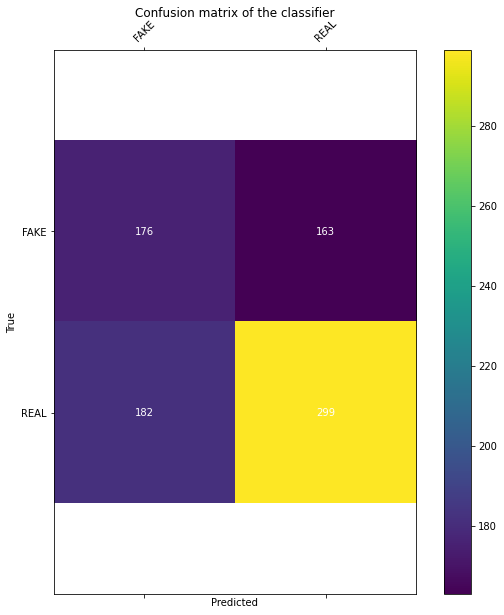

In [ ]:
n = round(len(train_data)/10)
x_test = train_data[:n+1]
x_train = train_data[n+1:]
n_train = train_classifier(x_train)
test_data = []
test_prediction = []
for data in x_test:
    test_data.append(data[0])
    test_prediction.append(data[1])
prediction = predict_labels(test_data, n_train)
confusion_matrix_heatmap(test_prediction,prediction,("FAKE","REAL"))

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = False  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[10])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t for t in test_data[1]]   # get the ground-truth labels from the data
    test_pred = predict_labels([x for x in test_data[0]], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])